Données Multimedia - Projet non-alternant - Statistiques descriptives
==============
---

# INSTALLATIONS

In [ ]:
!pip install -q moviepy
!pip install tqdm

# IMPORT

In [ ]:
import json #manipuler .json
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm   #barres de chargement pour les tâches longues (tracking)
import numpy as np
from google.colab import drive #acces au Drive

In [ ]:
drive.mount("/content/drive", force_remount=True)

chemin = 'drive/MyDrive/M2 SID/Last try/Projet non-alternant/Corpus/' #perso

Mounted at /content/drive


# DESCRIPTION

## test_videos

Ce dossier est théoriquement constitué de plusieurs milliers de vidéos au format mp4. Vérifions :

In [ ]:
chemin_test_videos = chemin + "test_videos/TestVideo/" #perso

dossier = !ls "$chemin_test_videos"
liste_elem = []
for sous_liste in dossier :
  for elem in sous_liste.split():
    liste_elem.append(elem)
liste_elem = sorted(liste_elem)
print(len(liste_elem))

fichiers_non_mp4 = []
for elem in liste_elem :
  if not(".mp4") in elem :
    fichiers_non_mp4.append(elem)

print(fichiers_non_mp4)

2990
[]


On a bien un fichier de test avec 2990 vidéos au format mp4 exclusivement.

In [ ]:
liste_durees = []
liste_width = []
liste_height = []
for video in tqdm(liste_elem, desc="Analyse des vidéos"):
  video_path = chemin_test_videos + video
  cap = cv2.VideoCapture(video_path)
  liste_width.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  liste_height.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  fps = cap.get(cv2.CAP_PROP_FPS)
  liste_durees.append(frame_count / fps)
  cap.release()

print("Durée moyenne :", np.mean(liste_durees))
print("Largeur moyenne :", np.mean(liste_width))
print("Hauteur moyenne :", np.mean(liste_height))

Analyse des vidéos:   0%|          | 0/2990 [00:00<?, ?it/s]

Durée moyenne : 15.055728675873198
Largeur moyenne : 320.0
Hauteur moyenne : 240.0


Donc notre corpus de test est constitué de vidéos en 240x320 d'une durée moyenne de 15 secondes.

## test_videodatainfo

In [ ]:
fichier = "test_videodatainfo.json"
with open(chemin + "json/" + fichier, "r", encoding="utf-8") as f:
    data = json.load(f)

print(data.keys())

dict_keys(['info', 'videos', 'sentences'])


Notre json est un fichier contenant 3 catégories de données : *info*, *videos* et *sentences*

In [ ]:
data["info"]

{'contributor': 'Microsoft MSM group',
 'data_created': '2016-04-14 14:30:20',
 'version': '1.0',
 'description': 'This is 1.0 version of the 2016 MSR-VTT dataset.',
 'year': '2016'}

Info contient, comme attendu, des informations sur la création du jeu de données

In [ ]:
print(len(data["videos"]))
print(data["videos"][0])

2990
{'category': 10, 'url': 'https://www.youtube.com/watch?v=Sa4BUsvAcjc', 'video_id': 'video7010', 'start time': 401.51, 'end time': 419.65, 'split': 'test', 'id': 7010}


Pour chaque vidéo, on a donc la classe renseignée, l'url (youtube) de ladite vidéo, son id (afin de la retrouver parmi les .mp4), l'extrait exact de la vidéo d'origine, l'appartenance au test (en opposition au train et à val peut-être), et un rappel de l'id (valeur numérique, redondance avec video_id ?)

In [ ]:
print(len(data["sentences"]) / 2990)
print(data["sentences"][0])

20.0
{'caption': 'a band performing in a small club', 'video_id': 'video7960', 'sen_id': 140200}


On a les catégories *caption* qui donne une description concise d'une vidéo, *video_id* qui renseigne de la vidéo concernée, et *sen_id* qui assigne un id à la phrase en question. Il y a 20 fois plus de phrases que de vidéos, vérifions si chaque vidéo a 20 phrases associées, ou si ce nombre varie :

In [ ]:
liste = [0] * 2990
data_sentences = data["sentences"]
for ligne in data_sentences :
  id = int(ligne["video_id"][5:]) - 7010
  liste[id] += 1
print("Nombre minimum de phrases par vidéo :", min(liste))
print("Nombre maximum de phrases par vidéo :", max(liste))

Nombre minimum de phrases par vidéo : 20
Nombre maximum de phrases par vidéo : 20


Toutes les vidéos ont donc bien 20 phrases associées.

In [ ]:
liste_longueurs = []
for ligne in data_sentences :
  liste_longueurs.append(len(ligne["caption"].split()))
print("Longueur max :", max(liste_longueurs))
print("Longueur min :", min(liste_longueurs))
for i in range(len(data_sentences)):
  if liste_longueurs[i] > 50 :
    print(data_sentences[i]["caption"])

Longueur max : 59
Longueur min : 3
a cartoon character from the spongebob squarepants speaks to the audience but no sounds is heard and then he gets on a bicycle and dons  some sort of a hat that looks like a water glass and rides away all the while a subtitle can be read on the lower left side of the screen saying oxytrex
a person is lying under a sheet in the morgue a woman discusses that some people in the nursing industry may feel they can handle it bea use they ve seen dead people before but it s a different story when it s their mom or dad or someone in their family and she begins explaining what embalmers do
a lady with red shirt and blue cover is in kitchen  and preparring some semi soild dish a pan is kept on a stove and some semisoild item is under cooking and the lady put some white powder then some green leaves cut piceses then some amount of liquid then she mixes the same with a woden sptulla


En terme de longueur, il ne semble pas y avoir de phrase choquante. On remarque tout de même des fautes de frappe/orthographe, donc il faudra potentiellement choisir des modèles robustes à ce genre de problème.

On va aussi essayer d'identifier des phrases abhérentes par la présence de caractères spéciaux potentiellement inappropriés :

In [ ]:
liste_char = []
for ligne in data_sentences :
  for char in ligne["caption"]:
    liste_char.append(char)
print("Caractères uniques :", set(liste_char))

Caractères uniques : {'y', '%', 'g', 'k', 'p', '\\', 'r', '$', 'c', 'é', ')', 'u', '4', 's', '2', 'в', '|', 'd', '1', '>', '&', 'v', '-', '3', '`', '.', '7', 'x', ' ', 'w', 'o', '’', 'i', '(', ':', '8', 'n', '/', 'a', 'l', '#', 'h', 'z', '[', 'q', 'm', 'f', 'j', '5', 'e', '9', 'b', 't', '+', '=', '6', '0'}


In [ ]:
liste_spec = []
dict_phrases_spec = dict()
for char in set(liste_char) :
  if not(char.isalpha()):
    liste_spec.append(char)
print(liste_spec)
for ligne in data_sentences :
  for spec in liste_spec :
    if spec in ligne["caption"]:
      dict_phrases_spec[ligne["caption"]] = spec
for phrase in dict_phrases_spec :
  print(repr(phrase), "=>", repr(spec))#print(set(liste_phrases_spec))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
'a man is speaking about a resolve that is needed to prevent violence' => '0'
'a man is speaking about an unfortunate event of someone passing' => '0'
'the world news is displaying a video of a person who has passed' => '0'
'roses and the letters are kept on the fence for the support' => '0'
'some roses and the wordings are kept on the fence for someone' => '0'
'a woman looking and touching roses on a busy sidewalk' => '0'
'a bbc news feed shows people leaving flowers in memory of the dead somewhere in south asia' => '0'
'reporter talks about some unspecified tragedy calling for tightened security' => '0'
'a few people is standing near red roses and white flowers on a fence' => '0'
'people stands around a fence with red roses and white flowers' => '0'
'bbc news story about military crackdown in an unknown asian country' => '0'
'a flower shop having red roses and other flowers decorated well' => '0'
'people le

Malheureusement, cette approche ne semble pas véritablement fonctionnelle...

Revenons sur les catégories :

In [ ]:
data_videos = pd.DataFrame(data["videos"])

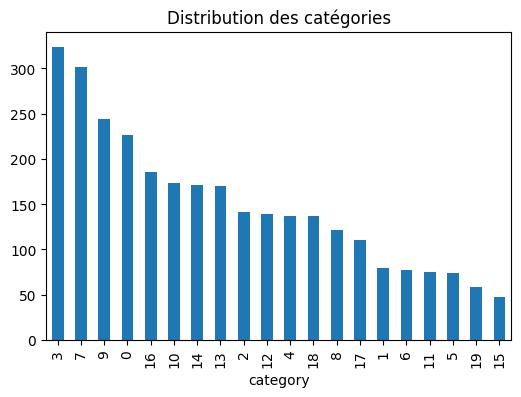

In [ ]:
distribution = data_videos["category"].value_counts()
distribution.plot(kind='bar', figsize=(6,4))
plt.title("Distribution des catégories")
plt.show()

On observe clairement que les catégories ne sont pas uniformément réparties. Les classes 3 et 7 sont les plus représentées, avec environ 6 fois plus d'effectif que les catégories 15 et 19.

## train_val_videos

On reprend les mêmes démarches que pour les vidéos de test :

In [ ]:
chemin_train_videos = chemin + "train_val_videos/TrainValVideo/" #perso

dossier = !ls "$chemin_train_videos"
liste_elem = []
for sous_liste in dossier :
  for elem in sous_liste.split():
    liste_elem.append(elem)
liste_elem = sorted(liste_elem)
print(len(liste_elem))

fichiers_non_mp4 = []
for elem in liste_elem :
  if not(".mp4") in elem :
    fichiers_non_mp4.append(elem)

print(fichiers_non_mp4)

7010
[]


Nous disposons de 7010 fichiers au format exclusivement .mp4

In [ ]:
liste_durees = []
liste_width = []
liste_height = []
for video in tqdm(liste_elem, desc="Analyse des vidéos"):
  video_path = chemin_train_videos + video
  cap = cv2.VideoCapture(video_path)
  liste_width.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  liste_height.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  fps = cap.get(cv2.CAP_PROP_FPS)
  liste_durees.append(frame_count / fps)
  cap.release()

print("Durée moyenne :", np.mean(liste_durees))
print("Largeur moyenne :", np.mean(liste_width))
print("Hauteur moyenne :", np.mean(liste_height))

Analyse des vidéos:   0%|          | 0/7010 [00:00<?, ?it/s]

Durée moyenne : 14.777067260184804
Largeur moyenne : 320.0
Hauteur moyenne : 240.0


On a encore des vidéos systématiquement 320x240 d'une quinzaine de secondes.

## train_val_videodatainfo

In [ ]:
fichier = "train_val_videodatainfo.json"
with open(chemin + "json/" + fichier, "r", encoding="utf-8") as f:
    data = json.load(f)

print(data.keys())

dict_keys(['info', 'videos', 'sentences'])


Notre json est un fichier contenant 3 catégories de données : *info*, *videos* et *sentences*

In [ ]:
data["info"]

{'contributor': 'Microsoft MSM group',
 'data_created': '2016-04-14 14:30:20',
 'version': '1.0',
 'description': 'This is 1.0 version of the 2016 MSR-VTT dataset.',
 'year': '2016'}

Info contient, comme attendu, des informations sur la création du jeu de données

In [ ]:
print(len(data["videos"]))
print(data["videos"][0])

7010
{'category': 9, 'url': 'https://www.youtube.com/watch?v=9lZi22qLlEo', 'video_id': 'video0', 'start time': 137.72, 'end time': 149.44, 'split': 'train', 'id': 0}


Pour chaque vidéo, on a donc la classe renseignée, l'url (youtube) de ladite vidéo, son id (afin de la retrouver parmi les .mp4), l'extrait exact de la vidéo d'origine, l'appartenance au test (en opposition au train et à val peut-être), et un rappel de l'id (valeur numérique, redondance avec video_id ?)

In [ ]:
print(len(data["sentences"]) / len(data["videos"]))
print(data["sentences"][0])

20.0
{'caption': 'a cartoon animals runs through an ice cave in a video game', 'video_id': 'video2960', 'sen_id': 0}


On a les catégories *caption* qui donne une description concise d'une vidéo, *video_id* qui renseigne de la vidéo concernée, et *sen_id* qui assigne un id à la phrase en question. Il y a 20 fois plus de phrases que de vidéos, vérifions si chaque vidéo a 20 phrases associées, ou si ce nombre varie :

In [ ]:
liste = [0] * len(data["videos"])
data_sentences = data["sentences"]
for ligne in data_sentences :
  id = int(ligne["video_id"][5:])
  liste[id] += 1
print("Nombre minimum de phrases par vidéo :", min(liste))
print("Nombre maximum de phrases par vidéo :", max(liste))

Nombre minimum de phrases par vidéo : 20
Nombre maximum de phrases par vidéo : 20


Toutes les vidéos ont donc bien 20 phrases associées.

Revenons sur les catégories :

In [ ]:
data_videos = pd.DataFrame(data["videos"])

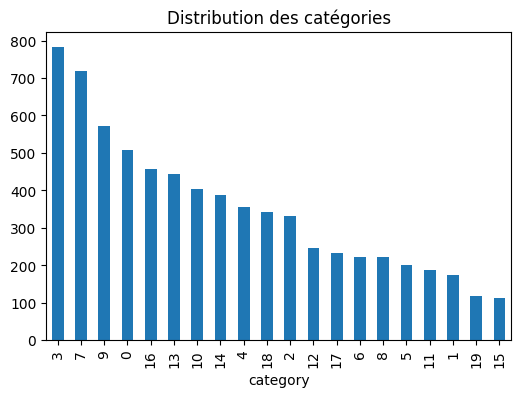

In [ ]:
distribution = data_videos["category"].value_counts()
distribution.plot(kind='bar', figsize=(6,4))
plt.title("Distribution des catégories")
plt.show()

On observe clairement que les catégories ne sont pas uniformément réparties. Les classes 3 et 7 sont les plus représentées, avec environ 6 fois plus d'effectif que les catégories 15 et 19. Cependant, la distribution est similaire dans le train et dans le test, ce qui est une bonne chose !